# Speech Emotion Recognition 

### Gender speech Clasification

In [1]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io.wavfile

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

Using TensorFlow backend.


In [2]:

# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('datasets/Audio_Speech_Actors_01-24/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [5]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                ])
#'intensity', 'statement', 'repetition', 'emotion'
count = 0
for i in dir_list:
    file_list = os.listdir('datasets/Audio_Speech_Actors_01-24/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'datasets/Audio_Speech_Actors_01-24/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
#         emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
#         if nm[3] == '01':
#             intensity = 0
#         else:
#             intensity = 1
        
#         if nm[4] == '01':
#             statement = 0
#         else:
#             statement = 1
        
#         if nm[5] == '01':
#             repeat = 0
#         else:
#             repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender]
        count += 1

In [6]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male


In [ ]:
data_df.source.unique()

In [13]:
data_df.gender.unique()

array(['male', 'female'], dtype=object)

In [14]:
filename = data_df.path[50]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

datasets/Audio_Speech_Actors_01-24/Actor_01/03-01-04-01-02-02-01.wav


(22050, array([-2.5870585e-07,  4.6514080e-07, -9.5607948e-07, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32))

In [15]:
len(samples), sample_rate

(74310, 22050)

In [16]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [17]:
sample_rate/ len(samples)

0.29672991522002423

Text(0.5, 0, 'Seconds')

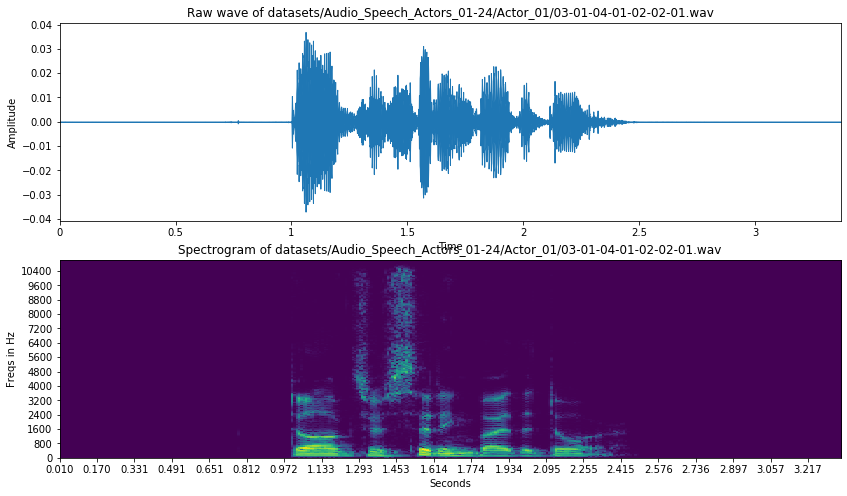

In [18]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [19]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [20]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.3593811e-05,  2.8816921e-06, -2.2359313e-06, ...,
        -3.8065782e-04, -2.4622300e-04, -9.4523741e-05], dtype=float32),
 array([21504, 53760]))

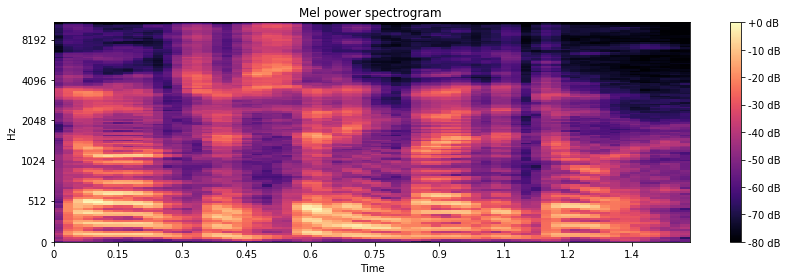

In [21]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

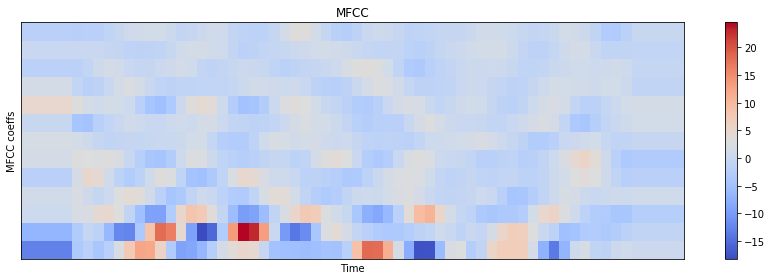

In [22]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [23]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [24]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [25]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [18]:

# label_list = []
# for i in range(len(data_df)):
#     if data_df.emotion[i] == 1:
#         lb = "_neutral"
#     elif data_df.emotion[i] == 2:
#         lb = "_calm"
#     elif data_df.emotion[i] == 3:
#         lb = "_happy"
#     elif data_df.emotion[i] == 4:
#         lb = "_sad"
#     elif data_df.emotion[i] == 5:
#         lb = "_angry"
#     elif data_df.emotion[i] == 6:
#         lb = "_fearful"
#     elif data_df.emotion[i] == 7:
#         lb = "_disgust"
#     elif data_df.emotion[i] == 8:
#         lb = "_surprised"
#     else:
#         lb = "_none"
        
#     # Add gender to the label 
#     label_list.append(data_df.gender[i]  + lb)
    
# len(label_list)

1440

In [19]:
# data_df['label'] = label_list
# data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8,male_surprised
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,8,male_surprised
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5,male_angry
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6,male_fearful
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6,male_fearful


In [26]:
data_df.gender.unique()

array(['male', 'female'], dtype=object)

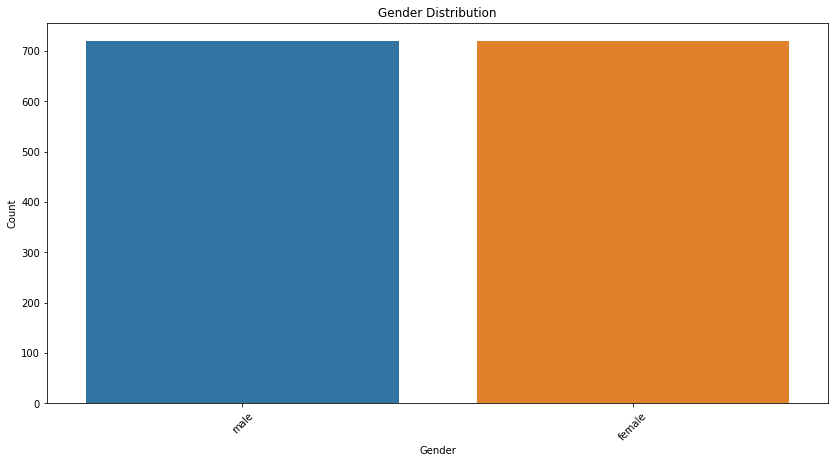

In [27]:
tmp_df = pd.DataFrame()
tmp_df['Gender'] = list(data_df.gender.unique())
tmp_df['Count'] = list(data_df.gender.value_counts())
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.barplot(x="Gender", y='Count', data=tmp_df)
ax.set_title("Gender Distribution")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

# Data Splitting

In [28]:
data2_df = data_df.copy()

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2, tmp3, tmp4],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()



1200


,path,source,actor,gender
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male


In [29]:
print (len(data3_df))
data3_df.head()

240


,path,source,actor,gender
0,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male
1,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male
2,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male
3,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male
4,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male


# Getting the features of audio files using librosa

In [30]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1200/1200 [00:40<00:00, 29.69it/s]


In [31]:
data.head()

,feature
0,"[-61.862373, -61.862373, -61.862373, -61.86237..."
1,"[-61.507996, -61.507996, -61.507996, -61.50799..."
2,"[-55.663086, -56.170334, -56.157845, -54.66347..."
3,"[-63.523525, -63.523525, -63.523525, -63.52352..."
4,"[-43.19739, -44.238605, -43.996212, -44.13236,..."


In [34]:
feature_df = pd.DataFrame(data['feature'].values.tolist())
gender = data2_df.gender

In [35]:
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,402,403,404,405,406,407,408,409,410,411
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
labeled_df = pd.concat([feature_df,gender], axis=1)

In [37]:
final_df = labeled_df.rename(index=str, columns={"0": "label"})
len(final_df)

1200

In [38]:
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,403,404,405,406,407,408,409,410,411,gender
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male


In [39]:
final_df.isnull().sum().sum()

165126

In [40]:
final_df = final_df.fillna(0)
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,403,404,405,406,407,408,409,410,411,gender
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male


In [41]:
final_df.gender.unique()

array(['male', 'female'], dtype=object)

In [42]:
final_df.shape

(1200, 413)

# Data Augmentation

In [43]:
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [44]:
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [45]:
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.7, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [49]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'gender'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    if data2_df.gender[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.gender[i]]

100%|██████████| 1200/1200 [00:38<00:00, 30.81it/s]


In [50]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'gender'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    if data2_df.gender[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.gender[i]]

100%|██████████| 1200/1200 [01:39<00:00, 12.02it/s]


In [38]:
# Augmentation Method 3

syn_data3 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = speedNpitch(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data3.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 1200/1200 [02:25<00:00,  8.23it/s]


In [51]:
len(syn_data1), len(syn_data2)

(1200, 1200)

In [52]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)
#syn_data3 = syn_data3.reset_index(drop=True)

In [53]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.gender
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "gender"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1200

In [54]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,gender
0,-50.557964,-49.955387,-51.150063,-51.548447,-49.255066,-49.574505,-51.127720,-48.806667,-47.123127,-48.720806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
1,-47.725273,-47.807259,-49.680359,-48.353828,-46.672810,-47.446487,-46.570965,-46.065212,-45.768776,-45.472092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
2,-43.162693,-42.073788,-41.659016,-42.326801,-41.396164,-42.087563,-44.130917,-43.966904,-42.690292,-42.719299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
3,-46.594650,-46.092258,-47.249306,-45.907852,-46.563747,-47.593594,-47.345741,-47.838161,-48.145283,-47.228745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
4,-29.179192,-29.871922,-30.181419,-28.164125,-27.548922,-26.774448,-26.473940,-27.320787,-28.137087,-27.983246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male


In [55]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.gender
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "gender"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1200

In [44]:
df4 = pd.DataFrame(syn_data3['feature'].values.tolist())
labels4 = syn_data3.label
syndf3 = pd.concat([df4,labels4], axis=1)
syndf3 = syndf3.rename(index=str, columns={"0": "label"})
syndf3 = syndf3.fillna(0)
len(syndf3)

1200

# combined only two augmented data

In [56]:
# Combining the Augmented data with original
combined_df = pd.concat([final_df, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,0,1,2,3,4,5,6,7,8,9,...,403,404,405,406,407,408,409,410,411,gender
0,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
1,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
2,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
3,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male
4,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male


In [57]:
#  Stratified Shuffle Split

X = combined_df.drop(['gender'], axis=1)
y = combined_df.gender
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# sss = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
# for train_index, test_index in sss.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [82]:
y.value_counts()

female    1800
male      1800
Name: gender, dtype: int64

In [58]:
y_train.value_counts()

female    1446
male      1434
Name: gender, dtype: int64

In [59]:
y_test.value_counts()

male      366
female    354
Name: gender, dtype: int64

In [49]:
#X_train.isna().sum().sum()

In [60]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [61]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [62]:
X_train.shape

(2880, 412)

# Changing dimension for CNN model

In [63]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [64]:
from keras import regularizers

In [65]:
model = Sequential()

model.add(Conv1D(256, 8,padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
# model.add(Activation('relu'))
# model.add(Conv1D(256, 8, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 8, padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(64, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Conv1D(64, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(y_train.shape[1]))
# model.add(Activation('softmax'))
########################################################### not Good ##########
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv1D(128, 8, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv1D(64, 8, padding='valid', activation='relu'))
# #model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.5))

# model.add(Conv1D(32, 8, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.25))
# model.add(Flatten())

# model.add(Dense(y_train.shape[1], activation='softmax'))
# opt = keras.optimizers.rmsprop(lr=0.0005, decay=1e-6)

################# NEW MODEL ###################
model.add(BatchNormalization())
model.add(Conv1D(128, 8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.20))

model.add(Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization())
model.add(Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization())       
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.30))

# model.add(Conv1D(265, 8, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Conv1D(128, 8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))      
# model.add(BatchNormalization())       
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.40))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.30))


model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.20))


model.add(Dense(y_train.shape[1], activation='softmax'))

adam = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 150, 256)          2304      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 256)          1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 143, 128)          262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 143, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 71, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 64)           

In [66]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [69]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.00015)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0001)
mcp_save = ModelCheckpoint('model/Gender_Class.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce, es])

Train on 2880 samples, validate on 720 samples
Epoch 1/100
2880/2880 [==============================] - 56s 20ms/step - loss: 0.2165 - accuracy: 0.9778 - val_loss: 0.3566 - val_accuracy: 0.9389
Epoch 2/100
2880/2880 [==============================] - 58s 20ms/step - loss: 0.2053 - accuracy: 0.9851 - val_loss: 0.3648 - val_accuracy: 0.9361
Epoch 3/100
2880/2880 [==============================] - 61s 21ms/step - loss: 0.2010 - accuracy: 0.9837 - val_loss: 0.5090 - val_accuracy: 0.8958
Epoch 4/100
2880/2880 [==============================] - 55s 19ms/step - loss: 0.2099 - accuracy: 0.9812 - val_loss: 0.3753 - val_accuracy: 0.9278
Epoch 5/100
2880/2880 [==============================] - 59s 20ms/step - loss: 0.1967 - accuracy: 0.9885 - val_loss: 0.3500 - val_accuracy: 0.9375
Epoch 6/100
2880/2880 [==============================] - 58s 20ms/step - loss: 0.1727 - accuracy: 0.9937 - val_loss: 0.3507 - val_accuracy: 0.9458
Epoch 7/100
2880/2880 [==============================] - 63s 22ms/step 

001 = loss: 2.7162 - accuracy: 0.1266
350 = loss: 0.5428 - accuracy: 0.8276 
700 = loss: 0.1255 - accuracy: 0.9773

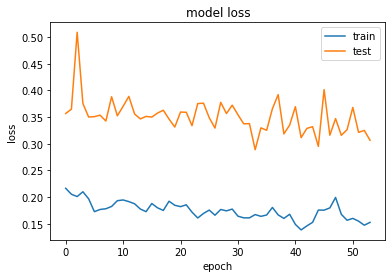

In [70]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [71]:
# Saving the model.json

import json
model_json = model.to_json()
with open("Gender_Class.json", "w") as json_file:
    json_file.write(model_json)

In [72]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('Gender_Class.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/Gender_Class.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 95.00%


In [73]:
print('Train Accuracy', cnnhistory.history['loss'][-1])
print('Test Accuracy', cnnhistory.history['val_loss'][-1])

Train Accuracy 0.1525621731662088
Test Accuracy 0.3064543770419227


In [74]:
cnnhistory.history['accuracy'][-1]

0.9892361

In [75]:
cnnhistory.history['val_accuracy'][-1]

0.9416666626930237

In [ ]:
# accuracy: 35.83% --> sr=16000
# accuracy: 28.98% --> sr=22050
# accuracy: 65.42% --> with data Augmented (Noise, Shift, speedNpitch )
# accuracy: 54.37% --> with Scalers and Data Augmented (Noise, Shift, speedNpitch)
# accuracy: 60.42% --> Male sound
# accuracy: 67.40% --> playing with opt & add hiden layer


# Multi Layer Perceptron Classifier

In [91]:
#Initializing the Multi Layer Perceptron Classifier

from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), 
                    learning_rate='adaptive', max_iter = 500)

In [92]:
#Training the model

classifier.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [93]:
#Prediction for the test set

y_pred = classifier.predict(X_test)

In [94]:
#Calculating the accuracy of our model

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = y_test, y_pred = y_pred)

In [95]:
#Printing the accuracy

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 92.36%
